In [114]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import datetime

# Importazione e lavorazione del dataset
In questa fase andiamo ad importare in pandas il dataset di esempio rinominandone una colonna per comodità.
Inoltre alla fine vogliamo vedere la struttura dei dati.

In [115]:
original_df = pd.read_csv('data/COVID19_line_list_data.csv') \
    .rename(columns={'reporting date':'reporting_date'})
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1085 non-null   int64  
 1   case_in_country        888 non-null    float64
 2   reporting_date         1084 non-null   object 
 3   Unnamed: 3             0 non-null      float64
 4   summary                1080 non-null   object 
 5   location               1085 non-null   object 
 6   country                1085 non-null   object 
 7   gender                 902 non-null    object 
 8   age                    843 non-null    float64
 9   symptom_onset          563 non-null    object 
 10  If_onset_approximated  560 non-null    float64
 11  hosp_visit_date        507 non-null    object 
 12  exposure_start         128 non-null    object 
 13  exposure_end           341 non-null    object 
 14  visiting Wuhan         1085 non-null   int64  
 15  from

## Lavorazione dei dati
In questa fase andiamo a clonare il dataset originale con le sole colonne che ci interessano.
Inoltre le colonne death e recovered riportano la data dell'evento ed uno '0' nel caso l'evento non sia presente. A noi interessa solo poter identificare solo l'evento stesso e non la data, quindi tramite due funzioni lambda andremo a modificare il contenuto delle colonne death e recovered.
Altra informazione che ci serve è la data: dall'analisi della struttura abbiamo visto che il campo data non è un tipo data, ma oggetto.
Di conseguenza applichiamo la funzione to_datetime di pandas per convertire l'oggetto in tipo data alla colonna reporting_date.
Infine, per convenienza, aggiungiamo una colonna confirmed con valore uguale ad 1 per ogni riga (il vecchio articolo di questo blog utilizzava un dataset che riportava anche casi non confermati).

In [116]:
df = original_df[['reporting_date', 'country', 'gender', 'age', 'death','recovered']].copy()
df['death'] = df['death'].apply(lambda x: 1 if x != '0' else 0)
df['recovered'] = df['recovered'].apply(lambda x: 1 if x != '0' else 0)
df['reporting_date'] = pd.to_datetime(df['reporting_date'])
df['confirmed'] = 1
df.info()
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   reporting_date  1084 non-null   datetime64[ns]
 1   country         1085 non-null   object        
 2   gender          902 non-null    object        
 3   age             843 non-null    float64       
 4   death           1085 non-null   int64         
 5   recovered       1085 non-null   int64         
 6   confirmed       1085 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 59.5+ KB


,reporting_date,country,gender,age,death,recovered,confirmed
0,2020-01-20,China,male,66.0,0,0,1
1,2020-01-20,China,female,56.0,0,0,1
2,2020-01-21,China,male,46.0,0,0,1
3,2020-01-21,China,female,60.0,0,0,1
4,2020-01-21,China,male,58.0,0,0,1
...,...,...,...,...,...,...,...
1080,2020-02-25,Austria,NaN,24.0,0,0,1
1081,2020-02-24,Afghanistan,NaN,35.0,0,0,1
1082,2020-02-26,Algeria,male,NaN,0,0,1
1083,2020-02-25,Croatia,male,NaN,0,0,1


In [117]:
df_countries_dates = df.groupby(['country', 'reporting_date']) \
    .agg(
        age_mean = ('age', 'mean'),
        age_max = ('age', 'max'),
        death_sum = ('death', 'sum'),
        recovered_sum = ('recovered', 'sum'),
        confirmed_sum = ('confirmed', 'sum')
        # {
        #    'age':['mean', 'max'],
        #    'death': 'sum',
        #    'recovered': 'sum' 
        # }
        ) \
    .reset_index() \
    .sort_values('reporting_date', ascending=False)

df_countries_dates['death_ratio'] = df_countries_dates.death_sum / df_countries.confirmed_sum
df_countries_dates['recovered_ratio'] = df_countries_dates.recovered_sum / df_countries.confirmed_sum

df_countries_dates = df_countries_dates.drop_duplicates(subset = ['country', 'reporting_date'])


df_countries_dates.head(1000)

,country,reporting_date,age_mean,age_max,death_sum,recovered_sum,confirmed_sum,death_ratio,recovered_ratio
205,Spain,2020-02-28,48.333333,81.0,0,0,9,NaN,NaN
260,UK,2020-02-28,NaN,NaN,0,0,4,NaN,NaN
59,Germany,2020-02-28,32.000000,32.0,0,0,6,NaN,NaN
252,UAE,2020-02-28,NaN,NaN,0,0,2,NaN,NaN
243,Thailand,2020-02-28,25.000000,25.0,0,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
26,China,2020-01-20,61.000000,66.0,0,0,2,0.0,0.0
175,South Korea,2020-01-20,35.000000,35.0,0,1,1,NaN,NaN
229,Thailand,2020-01-17,74.000000,74.0,0,0,1,NaN,NaN
97,Japan,2020-01-15,35.000000,35.0,0,1,1,NaN,NaN


## Grouping
Adesso vogliamo lavorare ulteriormente il dataset per raggruppare i dati per nazione (country) ed aggiungeremo anche delle colonne dopo il raggruppamento per identificare la frazione di morti sul totale e dei ricoveri sul totale.

In [118]:
df_countries = df.groupby(['country']) \
    .agg(
        age_mean = ('age', 'mean'),
        age_max = ('age', 'max'),
        death_sum = ('death', 'sum'),
        recovered_sum = ('recovered', 'sum'),
        confirmed_sum = ('confirmed', 'sum'),
        last_report_date = ('reporting_date', 'max'),
        first_report_date = ('reporting_date', 'min') 
        # altro sistema di grouping...
        # {
        #    'age':['mean', 'max'],
        #    'death': 'sum',
        #    'recovered': 'sum' 
        # }
        ) \
    .reset_index() \
    .sort_values('country', ascending=True)

df_countries['death_ratio'] = df_countries.death_sum / df_countries.confirmed_sum
df_countries['recovered_ratio'] = df_countries.recovered_sum / df_countries.confirmed_sum

df_countries = df_countries.drop_duplicates(subset = ['country'])


df_countries.head(1000)

,country,age_mean,age_max,death_sum,recovered_sum,confirmed_sum,last_report_date,first_report_date,death_ratio,recovered_ratio
0,Afghanistan,35.000000,35.0,0,0,1,2020-02-24,2020-02-24,0.000000,0.000000
1,Algeria,NaN,NaN,0,0,1,2020-02-26,2020-02-26,0.000000,0.000000
2,Australia,42.000000,65.0,0,4,15,2020-02-06,2020-01-25,0.000000,0.266667
3,Austria,24.000000,24.0,0,0,2,2020-02-25,2020-02-25,0.000000,0.000000
4,Bahrain,NaN,NaN,0,0,17,2020-02-25,2020-02-24,0.000000,0.000000
5,Belgium,NaN,NaN,0,0,1,2020-02-04,2020-02-04,0.000000,0.000000
6,Cambodia,60.000000,60.0,0,0,1,2020-01-27,2020-01-27,0.000000,0.000000
7,Canada,42.583333,65.0,0,2,12,2020-02-27,2020-01-26,0.000000,0.166667
8,China,49.000000,89.0,39,3,197,2020-01-27,2020-01-20,0.197970,0.015228
9,Croatia,NaN,NaN,0,0,1,2020-02-25,2020-02-25,0.000000,0.000000


# LET'S GRAPH
Adesso andiamo a creare dei grafici.
Il primo grafico vuole far vedere la differenza del numero di contagi per nazione rappresentati su una mappa.
A questo scopo utilizzeremo plotly.

In [119]:
fig = go.Figure(data=go.Choropleth(
    locations = df_countries['country'],
    locationmode = 'country names',
    z = df_countries['confirmed_sum'],
    colorscale = 'Reds',
    marker_line_color = 'black',
    marker_line_width = 0.5,
))

fig.update_layout(
    title_text = 'Casi confermati',
    title_x = 0.5,
    geo=dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    )
)

Per comodità togliamo la Cina dal dataset altrimenti renderebbe illeggibile il resto dei dati essendo un estremo molto distante dalla media degli altri dati.

In [120]:
df_countries_no_china = df_countries[df_countries['country'] != 'China']

fig = go.Figure(data=go.Choropleth(
    locations = df_countries_no_china['country'],
    locationmode = 'country names',
    z = df_countries_no_china['confirmed_sum'],
    colorscale = 'Reds',
    marker_line_color = 'black',
    marker_line_width = 0.5,
))

fig.update_layout(
    title_text = 'Casi confermati',
    title_x = 0.5,
    geo=dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    )
)

# Confronto del numero di contagi tra stati
Adesso vogliamo invece vedere la differenza degli stessi contagi tra uno stato e l'altro. Mentre il grafico precedente ci da questa idea solo tramite l'intensità di colore (ma rende l'idea dal punto di vista geografico), in questo grafico invece si vuole proprio mettere a confronto i casi per ogni stato in modo ordinato. 

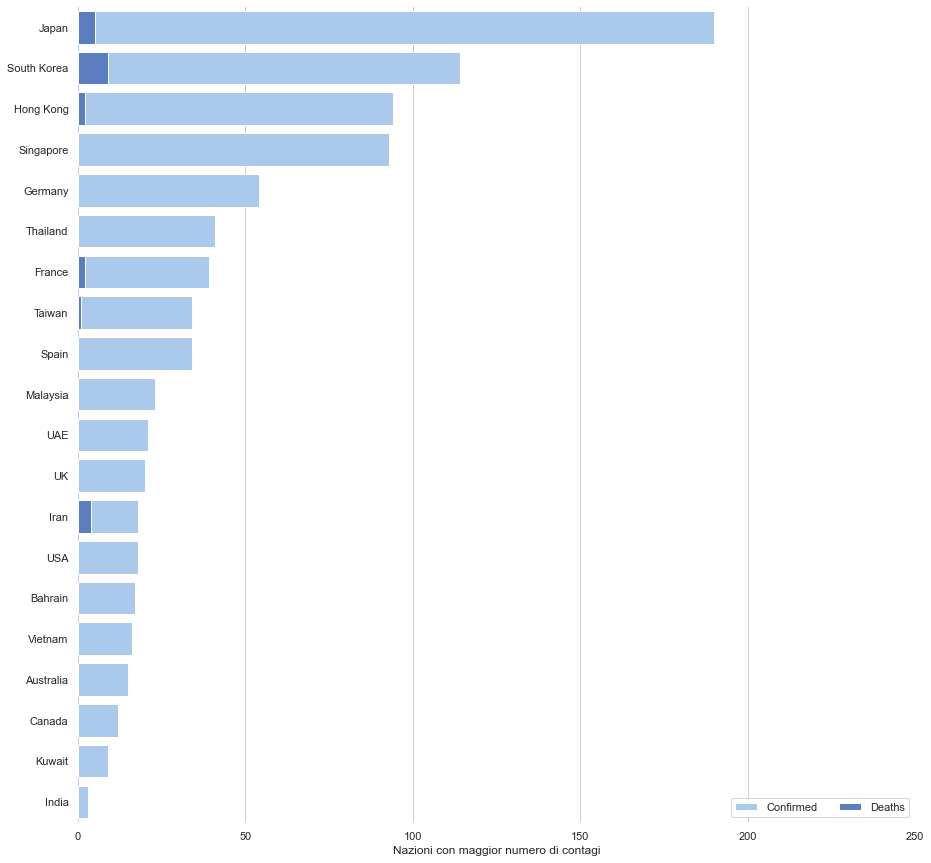

In [121]:
df_barplot = df_countries_no_china.sort_values(['confirmed_sum'], ascending=False).reset_index(drop=True).head(20)
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 15))
sns.set_color_codes("pastel")
sns.barplot(x="confirmed_sum", y="country", data=df_barplot,
            label="Confirmed", color="b")

sns.set_color_codes("muted")
sns.barplot(x="death_sum", y="country", data=df_barplot,
            label="Deaths", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 250), ylabel="",
       xlabel="Nazioni con maggior numero di contagi")
sns.despine(left=True, bottom=True)

# Analisi della mortalità correlata all'età
Altra analisi importante è legata all'età. Come abbiamo appreso dai media vengono colpite sopratutto persone anziane, ma più precisamente? Con un grafico come il seguente, è possibile analizzare la distribuzione di una serie di valori. Di conseguenza sarà sufficiente realizzare un array di tutte le età e seaborn per noi si prenderà carico di raggrupparle e visualizzarne la distribuzione.


In [122]:
df_age = df[df['age'] > 1]



df_age.head()

,reporting_date,country,gender,age,death,recovered,confirmed
0,2020-01-20,China,male,66.0,0,0,1
1,2020-01-20,China,female,56.0,0,0,1
2,2020-01-21,China,male,46.0,0,0,1
3,2020-01-21,China,female,60.0,0,0,1
4,2020-01-21,China,male,58.0,0,0,1


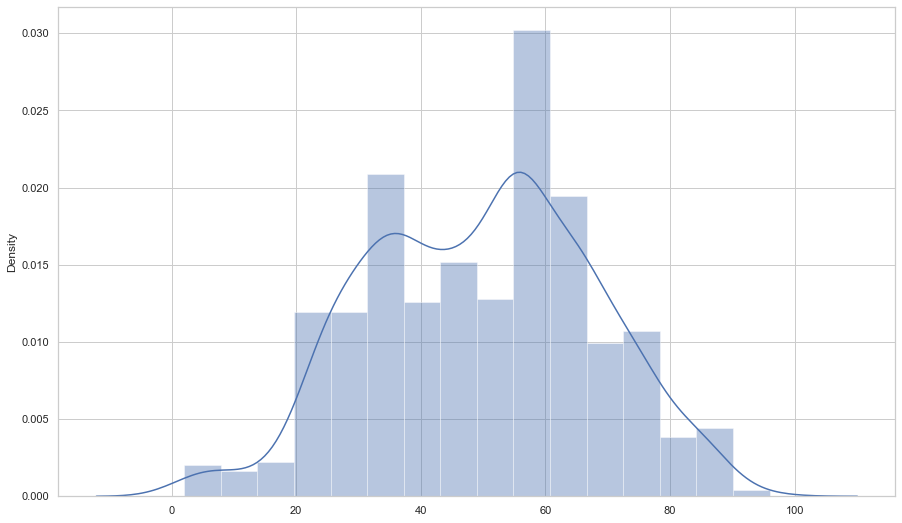

In [123]:
ages = df_age.age.values
f, ax = plt.subplots(figsize=(15, 9))
sns.distplot(ages, ax=ax);

# Distribuzione età dei deceduti per paese

<AxesSubplot:xlabel='age', ylabel='country'>

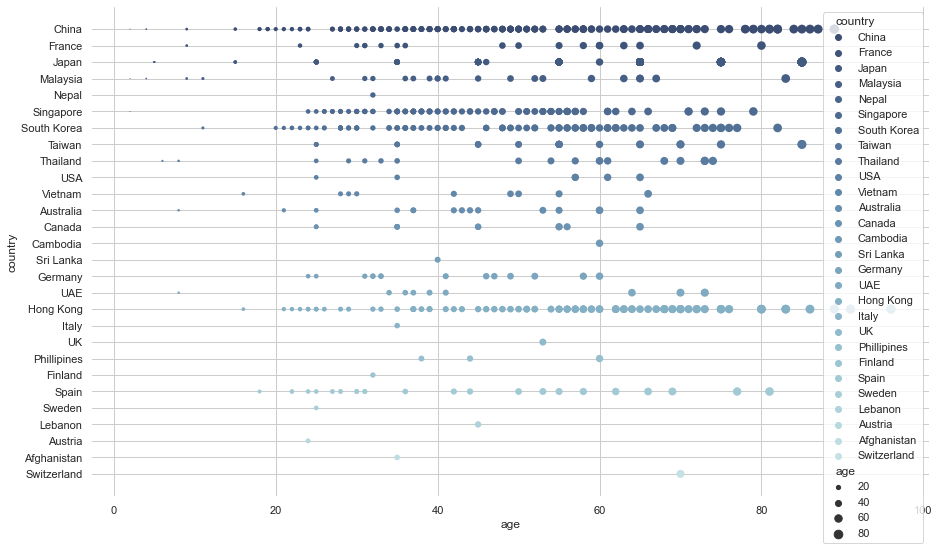

In [124]:
f, ax = plt.subplots(figsize=(15, 9))
sns.despine(f, left=True, bottom=True)
clarity_ranking = df_age.country.unique()
sns.scatterplot(x="age", 
                y="country",
                hue="country", 
                size="age",
                palette="ch:r=-.2,d=.3_r",
                hue_order=clarity_ranking,
                sizes=(1, 89), 
                linewidth=0,
                data=df_age, 
                ax=ax)

## Mappa di calore
Per l'esempio successivo invece abbiamo bisogno di eseguire un pivot del dataset in modo da avere una matrice bidimensionale dove troviamo in riga i vari stati, in colonna le età ed al loro incrocio il numero di elementi del dataset conteggiati. In questo modo è possibile instanziare un oggetto chiamato heatmap (sempre della libreria seaborn) che ci permette di avere una visualizzazione ancora più chiara della correlazione di queste due variabili.

In [125]:
df_deaths = df[df['death'] != 0].reset_index()
df_deaths_with_age = df_deaths[df_deaths['age'] > 0].reset_index()
df_deaths_with_age['counter'] = 1
df_deaths_by_country_age = df_deaths_with_age[['country','age', 'counter']] \
    .groupby(['country', 'age']) \
    .count() \
    .reset_index()

df_deaths_by_country_age.head()

,country,age,counter
0,China,36.0,1
1,China,48.0,1
2,China,53.0,1
3,China,55.0,1
4,China,58.0,2


In [126]:
df_deaths_by_country_age_pivoted = df_deaths_by_country_age.pivot('country', 'age')
df_deaths_by_country_age_pivoted

counter                                               ...       \
age            36.0 39.0 41.0 44.0 48.0 53.0 55.0 57.0 58.0 59.0  ... 78.0   
country                                                           ...        
China           1.0  NaN  NaN  NaN  1.0  1.0  1.0  NaN  2.0  NaN  ...  1.0   
France          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
Hong Kong       NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
Japan           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
Phillipines     NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
South Korea     1.0  NaN  1.0  NaN  NaN  NaN  NaN  2.0  1.0  1.0  ...  NaN   
Taiwan          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   

                                                          
age         79.0 80.0 81.0 82.0 84.0 85.0 86.0 87.0 89.0  
country                                                   
China        1.0  1.0  2.0  3.0  1.0  1.0  1.0  1.0  2.0  
France       NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Hong Kong    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Japan        NaN  NaN  NaN  NaN  NaN  3.0  NaN  NaN  NaN  
Phillipines  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
South Korea  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Taiwan       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[7 rows x 33 columns]

<AxesSubplot:xlabel='None-age', ylabel='country'>

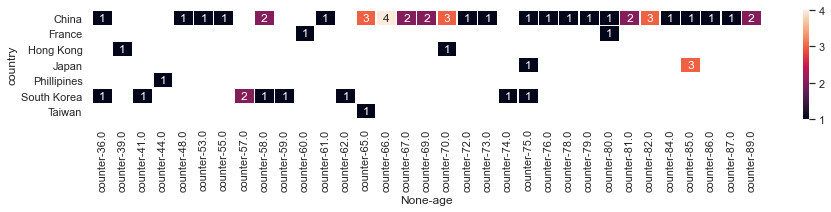

In [127]:
f, ax = plt.subplots(figsize=(15, 2))
sns.heatmap(df_deaths_by_country_age_pivoted, annot=True, linewidths=.5, ax=ax)